In [1]:
import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
sys.path.append("/Users/roberto/code/corelibs/src/tools-python")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes/datatypes_python")
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *
import module
import settings

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 28})
plt.rcParams['text.usetex'] = True
plt.rc("text", usetex=True)
plt.rc("font", family='serif')
module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

from mrg.logging.monolithic_encoder import encodeForMonolithic
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python/"
                "protobuf/classification_score")
import pbClassificationScore_pb2 as pbClassificationScore_pb2

import numpy as np
from config.data import *

In [347]:
def trainSVM(numElems=5,num_scans_used=18):
    # Train
    from sklearn.svm import SVC

    # filename = '/Users/roberto/data/RO-logging/2019-02-06-11-52-52/tmp_combined_data.csv';
    # filename = '/Users/roberto/data/RO-logging/datasets/ro-eigenvecs/maxEVecs-ro-dataset.csv';
    dateAndTime = "2019-03-18-15-00-42-velCorrectorOn/";
    filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
    "2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"\
    "motion_estimation/standard-ro/"+dateAndTime+'tmp_combined_data.csv';

    print('Reading from: ' + filename)
    df_combined_data = pd.read_csv(filename, names=range(2400))
    df_maxEVecs = df_combined_data.iloc[:,1:] #pd.read_csv(filename, names=range(2400))

    df_labels = df_combined_data.iloc[:,0:1]
    labels = np.copy(df_labels.values)
    labels = labels.T

    [m,n] = shape(df_maxEVecs)

    print("Shape of max eigenvecs is:\n",shape(df_maxEVecs))
    print("Shape of labels is:\n",shape(df_labels))
    print("Shape of data is:\n",shape(df_combined_data))

    # Filter labels
    import scipy.signal
    raw_labels = ravel(labels)
    filtered_labels = np.array(raw_labels)
    filtered_labels = scipy.signal.medfilt(filtered_labels,5)

    # Take evenly spaced elements as features
    arr = np.copy(df_maxEVecs.values)
#     numElems = 5#40
    eig_len = arr.shape[1]
    idx = np.round(np.linspace(0, eig_len - 1, numElems)).astype(int)
    train_features = []
    for eig_idx in range(0,m):
        train_features.append(arr[eig_idx][idx])
    df_features = pd.DataFrame(train_features)

    # Take previous eigenvector features and add them to the list
#     num_scans_used = 18
    for scan_idx in range(1,num_scans_used):
        for elem_idx in range (0,numElems):
            col_idx = elem_idx+numElems*scan_idx
            df_features[col_idx] = df_features[elem_idx].iloc[:-1]
            df_features[col_idx] = df_features[col_idx].shift(scan_idx)
            df_features.loc[0:scan_idx,col_idx] = df_features[elem_idx].iloc[0]
    print('Shape of features:',df_features.shape)

    # Process data for training
    from sklearn.model_selection import StratifiedShuffleSplit

    maxEVecs = np.array(df_maxEVecs.values)
    # y_labels = ravel(labels)
    y_labels = filtered_labels # try to reduce label noise
    y_labels_raw = ravel(labels)

    print('Good RO: ',np.count_nonzero(y_labels==-1))
    print('Bad RO:',np.count_nonzero(y_labels==1),'\n')

    X_total = np.copy(df_features.values)
    y_total = np.copy(y_labels)
    y_total_raw = np.copy(y_labels_raw)

    sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=0)

    for train_index, test_index in sss.split(X_total, y_total,y_total_raw):
        X_train, X_test = X_total[train_index], X_total[test_index]
        y_train, y_test = y_total[train_index], y_total[test_index]
        y_train_raw, y_test_raw = y_total_raw[train_index], y_total[test_index]
        eig_train, eig_test = maxEVecs[train_index], maxEVecs[test_index]

    print('Good vs Bad RO in training: ',np.count_nonzero(y_train==-1),'good,',np.count_nonzero(y_train==1),'bad')
    print('Good vs Bad RO in testing:',np.count_nonzero(y_test==-1),'good,',np.count_nonzero(y_test==1),'bad \n')

    print('Good/Bad ratio in training: ',np.count_nonzero(y_train==-1)/np.count_nonzero(y_train==1))
    print('Good/Bad ratio in testing:',np.count_nonzero(y_test==-1)/np.count_nonzero(y_test==1),'\n')

    print('Bad RO % in training: ',np.count_nonzero(y_train==1)/y_train.shape[0])
    print('Bad RO % in testing:',np.count_nonzero(y_test==1)/y_test.shape[0],'\n')

    [m_train,n_train] = shape(X_train)
    [m_test,n_test] = shape(X_test)
    print("Size of training data is: \n",shape(X_train))
    print("Size of test data is: \n",shape(X_test))

    from sklearn import preprocessing

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_scaled = preprocessing.scale(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Calculate metrics
    from sklearn.svm import SVC
    from sklearn.metrics import f1_score,precision_score,recall_score
    from sklearn.metrics import average_precision_score

    # SVM Classifier model
    clf = SVC(kernel="linear",class_weight='balanced', C=float(1),gamma=0.001,random_state=0)
    print(clf.fit(X_train, y_train))

    y_predictions_X_train = clf.predict(X_train)
    dec_func_X_train = clf.decision_function(X_train)

    print('\nTrain metrics:')
    print('Accuracy:',clf.score(X_train,y_train))
    print('Precision:',precision_score(y_train,y_predictions_X_train))
    print('Recall:',recall_score(y_train,y_predictions_X_train))
    print('F1 score:',f1_score(y_train,y_predictions_X_train))
    print('Average precision:',average_precision_score(y_train,dec_func_X_train))

    # y_predictions_X_test = clf.predict(X_test)
    # dec_func_X_test = clf.decision_function(X_test)

    # print('\nTest metrics:')
    # print('Accuracy:',clf.score(X_test,y_test))
    # print('Precision:',precision_score(y_test,y_predictions_X_test))
    # print('Recall:',recall_score(y_test,y_predictions_X_test))
    # print('F1 score:',f1_score(y_test,y_predictions_X_test))
    # print('Average precision:',average_precision_score(y_test,dec_func_X_test))

    from sklearn import metrics
    from sklearn.model_selection import cross_val_score
    tmp_score = 'average_precision'
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring=tmp_score)
    print('\nCross validation:\n',scores)
    print('Mean average precision score:',scores.mean())
    print('Std dev average precision score:',scores.std())
    
    print('Training complete!')
    return(clf,scaler,X_total)

In [297]:
def extractElementsFromEigvec(eigvec,numElems=5):
#     print('Extracting features...')
    # Take evenly spaced elements as features
    arr = np.array(eigvec)
    eig_len = len(arr)
    idx = np.round(np.linspace(0, eig_len - 1, numElems)).astype(int)
    eig_features = arr[idx]
#     print(eig_features)
    return(eig_features)

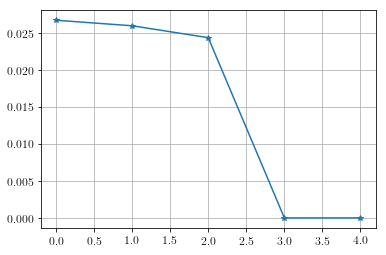

In [298]:
tmp_eigvec = df_maxEVecs.iloc[0]
eig_features = extractElementsFromEigvec(tmp_eigvec)
plt.plot(eig_features,'*-');

In [299]:
from collections import deque
N = num_scans_used
previousF = deque()
currentF = eig_features

def extractFeatures(currentFeatures,previousFeatures,numElems=5):
# Take previous eigenvector features and add them to the list
# Remove older features, shift features along, add latest features
    combinedFeatures = previousFeatures
    combinedFeatures.extend(currentFeatures)
    if(len(combinedFeatures) > (N*numElems)):
        [combinedFeatures.popleft() for _i in range(numElems)]
    return(combinedFeatures)

# combinedFeatures = extractFeatures(currentF,previousF)
# print(combinedFeatures)

temp_eigvecs = np.array(df_maxEVecs.iloc[0:30])
tmp_data = []
combinedFeatures = deque()
for i in range(25):
    prevF = combinedFeatures
    tmp = extractElementsFromEigvec(temp_eigvecs[i])
    combinedFeatures = extractFeatures(tmp,prevF)
shape(combinedFeatures)

(90,)

In [326]:
def classifyOnFeatures(clf,scaler,combinedFeatures,N=18,numElems=5):
    if(len(combinedFeatures) >= (N*numElems)):
        # reshape
        sample = np.array(combinedFeatures)
        sample = sample.reshape((1,sample.shape[0]))
        # run classifier
        X_data = scaler.transform(sample)
        score = clf.predict(X_data)
    else:
        # not enough eigenvectors yet
        score = -1 # assume good RO
    return score

# score = classifyOnFeatures(clf,scaler,combinedFeatures)
# print(score)

In [331]:
def runClassifier(eigvec,total_features):
#     print('Running classification on current eigenvector...')
    latest_features = extractElementsFromEigvec(eigvec)
    total_features = extractFeatures(latest_features,total_features)
    score = classifyOnFeatures(clf,scaler,total_features)
    return(score)
    

In [343]:
total_features = deque()
tmp_scores = []
for i in range(len(X_total)):
    score = runClassifier(df_maxEVecs.iloc[i],total_features)
    tmp_scores.append(score)
#     print(score)

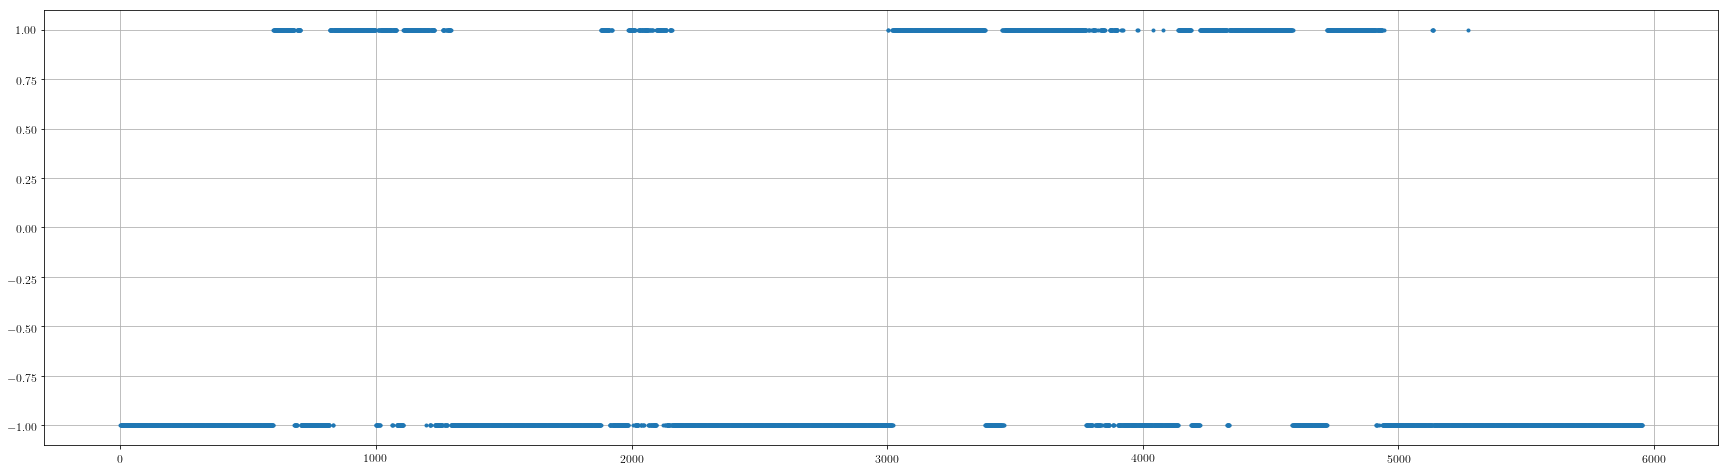

In [345]:
plt.figure(figsize=(30,8))
plt.plot(tmp_scores,'.')

In [363]:
tmpvec = [4,3,2,1]
bigvec = np.zeros(10)
bigvec[:len(tmpvec)]=tmpvec
print(bigvec)

[4. 3. 2. 1. 0. 0. 0. 0. 0. 0.]


Current eigvec features: [0.0267034, 1614, 39.88041469]


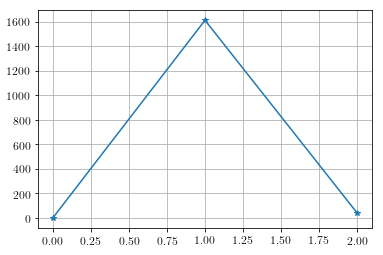

In [380]:
def extractCustomFeaturesFromEigvec(eigvec,num_elems=5):
#     print('Extracting features...')
    eig_features = []
    arr = np.array(eigvec)
    arr_fixed_length = np.zeros(2400)
    arr_fixed_length[:len(arr)] = arr 
    sorted_max_evec = sort(arr_fixed_length)[::-1]
    max_val = sorted_max_evec[0]
    num_landmarks = count_nonzero(sorted_max_evec)
    area_under_curve = []
    temp_sum = 0;
    for i in range(len(arr)):
        temp_sum += arr[i]
    area_under_curve = temp_sum
    eig_features.append(max_val)
    eig_features.append(num_landmarks)
    eig_features.append(area_under_curve)
    print('Current eigvec features:',eig_features)
    return(eig_features)

tmp_eigvec = df_maxEVecs.iloc[0]
eig_features = extractCustomFeaturesFromEigvec(tmp_eigvec)
plt.plot(eig_features,'*-');